In [2]:

import pymdp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd


In [3]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

## Changed functions
Expected states to factor in extra dimensions in B-tensor.

In [4]:
#collapse tumor by resistance, t-1 beliefs
collapse_list_tumor = [(1, -1)]

#collapse resistance by tumor, t0 beliefs
collapse_list_resistance = [(0, 0)]

#make a list of collapsing workflows ordered by factor
collapse_list = [collapse_list_tumor, collapse_list_resistance, []]

def get_expected_states(qs, B, policy):
    """
    Compute the expected states under a policy, also known as the posterior predictive density over states

    Parameters
    ----------
    qs: ``numpy.ndarray`` of dtype object
        Marginal posterior beliefs over hidden states at a given timepoint.
    B: ``numpy.ndarray`` of dtype object
        Dynamics likelihood mapping or 'transition model', mapping from hidden states at ``t`` to hidden states at ``t+1``, given some control state ``u``.
        Each element ``B[f]`` of this object array stores a 3-D tensor for hidden state factor ``f``, whose entries ``B[f][s, v, u]`` store the probability
        of hidden state level ``s`` at the current time, given hidden state level ``v`` and action ``u`` at the previous time.
    policy: 2D ``numpy.ndarray``
        Array that stores actions entailed by a policy over time. Shape is ``(num_timesteps, num_factors)`` where ``num_timesteps`` is the temporal
        depth of the policy and ``num_factors`` is the number of control factors.

    Returns
    -------
    qs_pi: ``list`` of ``numpy.ndarray`` of dtype object
        Predictive posterior beliefs over hidden states expected under the policy, where ``qs_pi[t]`` stores the beliefs about
        hidden states expected under the policy at time ``t``
    """
    n_steps = policy.shape[0]
    n_factors = policy.shape[1]

    # initialise posterior predictive density as a list of beliefs over time, including current posterior beliefs about hidden states as the first element
    qs_pi = [qs] + [pymdp.utils.obj_array(n_factors) for t in range(n_steps)]
    
    # get expected states over time
    for t in range(n_steps):

        for control_factor, action in enumerate(policy[t,:]):
            
            #figure out which B matrix to use
            collapse_workflows = collapse_list[control_factor]
            
            #Get all slices for the chosen action
            B_factor = B[control_factor][...,int(action)]
            if len(collapse_workflows) > 0:

                #for each collapse which is a (factor and timeoffset), 
                for workflow in collapse_workflows:
                    #get timesteps of belief and what state to collapse by
                    factor, time_offset = workflow

                    #Get the dot.product to collapse the b
                    B_factor = B_factor.dot(qs_pi[t+time_offset+1][factor])

            #calculate expected posterior of the state for the timestep given the action
            qs_pi[t+1][control_factor] = B_factor.dot(qs_pi[t][control_factor])

    #Return a list of expected states given the policy
    return qs_pi[1:]

pymdp.control.get_expected_states = get_expected_states

In [5]:
#define names tumor names
tumor_names = ['t1', 't2', 't3', 't4', 't5', 't6']

#the same for resistances
resistance_names = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6']

#treatment names
treatment_names = ['no treatment', 'treatment']

#define the state factor array 
num_states = [len(tumor_names), len(resistance_names), len(treatment_names)]
num_factors = len(num_states)

#no possible action for tumor and resistance factor
tumor_action_names = ['Do nothing']
resistance_action_names = ['Do nothing']

#can decide to treat or not
treatment_action_names = ['dont treat', 'treat']
                      
#Define number of control states
num_controls = [len(tumor_action_names), len(resistance_action_names), len(treatment_action_names)]

#Define observation states 
tumor_observation_names = tumor_names
treatment_observation_names = treatment_names

#only tumor level is and treatment are observable, but others could be added.
num_observations = [len(tumor_observation_names), len(treatment_observation_names)]

num_modalities = len(num_observations)



In [6]:
#sim settings
tumor_increase_prob = 0.3
resistance_increase_prob = 0.5 
treatment_effect_probs = [1, .8, .6, .5, .4, .2]
resistance_decrease_probs = [.0, .2, .4, .7, .8, .9]
tumor_starting_state = 0 
resistance_starting_state = 0
treatment_starting_state = 0

## Code likelihoods

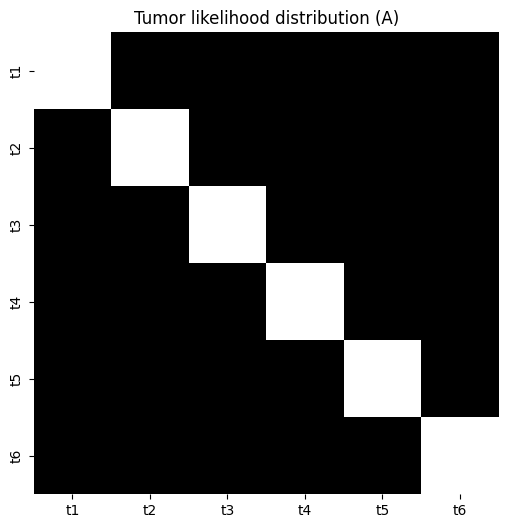

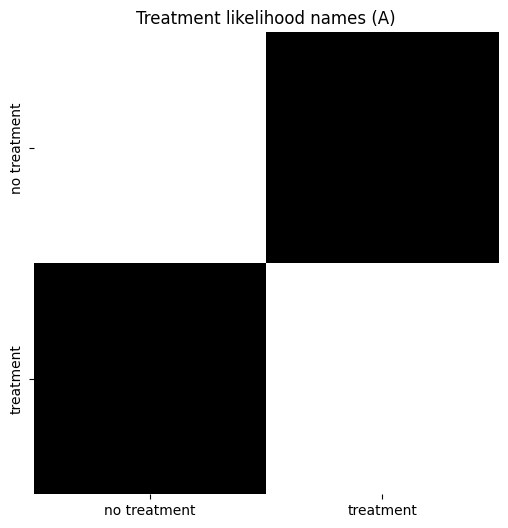

In [7]:
#Create A likelihood matrix per modality. Since there are only two observable outcomes, tumor level and treatment, there will be two likelihood arrays
#Create an empty array to store the likelihoods
A = pymdp.utils.obj_array( num_modalities )

#Create a likelihood matrix for the tumor modality
A_tumor = np.zeros((len(tumor_observation_names), len(tumor_names), len(resistance_names), len(treatment_names)))
                   
#Fill in the likelihood matrix for the tumor modality, with perfect observation of the tumor level
for i in range(len(tumor_observation_names)):
    for j in range(len(tumor_names)):     
        #if on the diagonal, the observation is correct
        if i == j:
            A_tumor[i, j, :, :] = 1.0

#Store the likelihood matrix for the tumor modality in the likelihood array
A[0] = A_tumor

#Create a likelihood matrix for the treatment modality
A_treatment = np.zeros((len(treatment_observation_names), len(tumor_names), len(resistance_names), len(treatment_names)))

#Fill in the likelihood matrix for the treatment modality, with perfect observation of the treatment
for i in range(len(treatment_observation_names)):
    for j in range(len(treatment_names)):     
        #if on the diagonal, the observation is correct
        if i == j:
            A_treatment[i, :, :, j] = 1.0

#Store the likelihood matrix for the treatment modality in the likelihood array
A[1] = A_treatment


#Plot the likelihood matrix for the tumor modality to check. Pick the first state of the resistance factor and no treatment
plot_likelihood(A_tumor[:, :, 0, 0], xlabels = tumor_names, ylabels = tumor_observation_names, title_str = "Tumor likelihood distribution (A)")

#For treatments
plot_likelihood(A_treatment[:, 1, 2, :], xlabels = treatment_names, ylabels = treatment_observation_names, title_str = "Treatment likelihood names (A)")

## Transition probabilities
Make a transition probability matrix for each state factor. Means that $B[0]$ correpsonds to tumor transition probabilities, and that $B[1]$ to resistance transition probabilties.

In [8]:
#Set the number of sub-arrays equal to number of factors
B = pymdp.utils.obj_array(num_factors) 

##change to function

#Create B_tumor for tumor factor
B_tumor = np.zeros( (len(tumor_names), len(tumor_names), len(resistance_names), len(treatment_names)))

#fill in no treatment cancer progression. 
#rows correspond to the next state, columns to the current state. If treatment equals no treatment, the risk of tumor progression is simply the risk of tumor progression. #iterate through all resistance states and set one below the diagonal to the risk of tumor progression
for i in range(len(resistance_names)):

    #fill the diagonal with 1 - tumor_increase_prob
    np.fill_diagonal(B_tumor[:, :, i, 0], 1 - tumor_increase_prob)

    #fill the one below the diagonal with tumor_increase_prob
    np.fill_diagonal(B_tumor[1:, :, i, 0], tumor_increase_prob)

    #if tumor is at the top level, it can't increase anymore
    B_tumor[-1, 5, i, 0] = 1.0


#fill in treatment cancer progression. during treatment the chance of tumor progression depends on the resistance level.
for i in range(len(resistance_names)):

    #find the chance of treatment working given the resistance level
    treatment_succeeds = treatment_effect_probs[i]

    #the chance of reduction is the both the chance of progression doesn't happen and that treatment succeeds
    chance_of_reduction = treatment_succeeds * (1 - tumor_increase_prob)

    #chance of no reduction is the chance of progression happening and treatment succeding or treatment failing and progression not happening
    chance_of_no_change =  treatment_succeeds * tumor_increase_prob + (1 - treatment_succeeds) * (1 - tumor_increase_prob)

    #chance of increase in tumor is the chance of treatment failing and progression happening
    chance_of_increase = (1 - treatment_succeeds) * tumor_increase_prob

    #fill in transition probs for treatment working given the resistance level
    np.fill_diagonal(B_tumor[:, 1:, i, 1], chance_of_reduction)
    np.fill_diagonal(B_tumor[:, :, i, 1], chance_of_no_change)
    np.fill_diagonal(B_tumor[1:, :, i, 1], chance_of_increase)

    #if the tumor is at minimal state, it treatment isn't applied and it therefore can't be reduced any more. The chance of staying is therefore whatever is left after the risk of increasing and treatment failing. This is equal to tumor not progressing or tumor progressing and treatment working.
    B_tumor[0,0,i,1] = 1 - chance_of_increase

    #if the tumor is at maximal state, it can't increase anymore, the chance of staying is therefore everything except for reduction
    B_tumor[-1, -1, i, 1] = 1 - chance_of_reduction

#initialize the B_treatment matrix
B_resistance = np.zeros((len(resistance_names), len(resistance_names), len(tumor_names), len(treatment_names)))


#fill in no treatment resistance progression. Diagonal is chance of resistance not increasing, one below diagonal is chance of resistance increasing, and one above diaganol is chance of resistance decreasing
for i in range(len(tumor_names)):

    #Find the chance of resistance decreasing given the tumor level
    resistance_decrease_prob = resistance_decrease_probs[i]

    #chance of reducing the resistance level depends on the tumor level
    chance_of_reduction_no_treatment = resistance_decrease_prob

    #Probability of of no change can only happen if the resistance isn't reduced when treatment isn't given. 
    chance_of_no_change_no_treatment = 1 - chance_of_reduction_no_treatment

    #fill in transition probs for no treatment
    np.fill_diagonal(B_resistance[:, 1:, i, 0], chance_of_reduction_no_treatment)
    np.fill_diagonal(B_resistance[:, :, i, 0], chance_of_no_change_no_treatment)

    #when treatment is off and resistance is at lowest level, resistance can't decrease anymore
    B_resistance[0, 0, i, 0] = 1.0

    #The risk of progressing in resistance
    chance_of_increase_treatment = resistance_increase_prob

    #chance of reduction is the chance of resistance not increasing
    chance_of_no_change_treatment = (1 - resistance_increase_prob)

    #fill in transition probs for treatment
    #np.fill_diagonal(B_resistance[:, 1:, i, 1], chance_of_reduction_treatment)
    np.fill_diagonal(B_resistance[:, :, i, 1], chance_of_no_change_treatment)
    np.fill_diagonal(B_resistance[1:, :, i, 1], chance_of_increase_treatment)

    #when treatment is on and resistance is at its highest level, resistance can't increase anymore, instead it just stays at same level since treatment is applied
    B_resistance[-1, -1, i, 1] = 1.0


#fill in TPMs for deciding to treat. This always is perfect probability of choosing the treatment transitions into treatment
B_treatment = np.zeros((len(treatment_names), len(treatment_names), len(treatment_action_names)))

#setup matrix for controlling treatment. Treatment is always perfectly applied
for i in range(len(treatment_names)):
    B_treatment[i,:,i] = 1 

#save the matricies to the B array
B[0] = B_tumor
B[1] = B_resistance
B[2] = B_treatment

#Set collapsing list
#collapse tumor by resistance, t-1 beliefs
collapse_list_tumor = [(1, -1)]

#collapse resistance by tumor, t0 beliefs
collapse_list_resistance = [(0, 0)]

#make a list of collapsing workflows ordered by factor
collapse_list = [collapse_list_tumor, collapse_list_resistance, []]


## Setup C prior Dist Preferences

One C-matrix per outcome-modality, where rows correspond to level and columns correspond to timepoints.


Should it have temporal discounting? PYMDP looks different to matalb. Setting the probability of an outcome equal to the 100-timepoint and then softmaxing could probably do it.

Perhaps make these emperically based on adapative protocol or random treatment behavior.



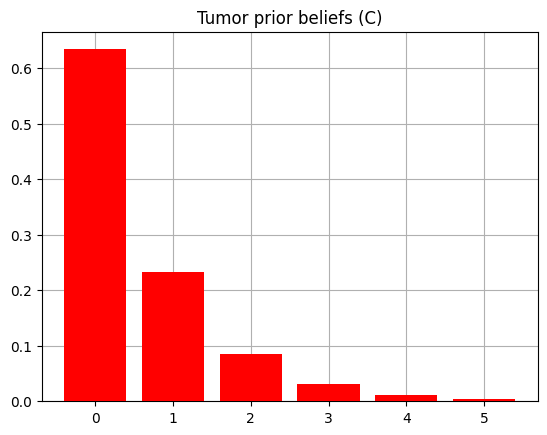

In [9]:
C = pymdp.utils.obj_array(num_modalities)

C_tumor = np.zeros(len(tumor_names))
#Create C_tumor for tumor factor
for i in range(len(tumor_names)):
    C_tumor[i] = (len(tumor_names) - i) - 1

C[0] = C_tumor

C_treatment = np.zeros(len(treatment_names))

C[1] = C_treatment

plot_beliefs(pymdp.maths.softmax(C_tumor), title_str = "Tumor prior beliefs (C)")







## Setup prior beliefs D-vectors
Could probably be varied over different for different states. Doesn't currently correspond to starting state

In [10]:
D = pymdp.utils.obj_array(num_factors)

#set perfect knowledge for tumor
D_tumor = np.zeros((len(tumor_names)))
D_tumor[:] =  1/len(tumor_names)

#set perfect knowledge for resistance
D_resistance = np.zeros((len(resistance_names)))
D_resistance[:] = 1/len(resistance_names)

#set perfect knowledge for treatment
D_treatment = np.zeros((len(treatment_names)))
D_treatment[:] = 1/len(treatment_names)

D[0] = D_tumor
D[1] = D_resistance
D[2] = D_treatment


## Setup Discrete Env Class
Takes values from the simulation parameters such as the starting tumor_State, resistance state, progression risks of both tumor and resistance levels, and more. Use .step("action"), to increment the enviorment, and .reset() to reset it.

In [11]:
class DiscreteTumorEnv():

    #initialize the class, to set startint state to tuple (0,0)
    def __init__(self, tumor_starting_state = tumor_starting_state, resistance_starting_state = resistance_starting_state, treatment_starting_state = treatment_starting_state, tumor_increase_prob = tumor_increase_prob, resistance_increase_prob = resistance_increase_prob, treatment_effect_probs = treatment_effect_probs, resistance_decrease_probs = resistance_decrease_probs):
        
        #simulation parameters
        self.tumor_increase_prob = tumor_increase_prob
        self.resistance_increase_prob = resistance_increase_prob
        self.treatment_effect_probs = treatment_effect_probs
        self.resistance_decrease_prob = resistance_decrease_probs

        #set the starting state for each factor
        self.init_tumor_state = tumor_starting_state
        self.init_resistance_state = resistance_starting_state
        self.init_treatment_state = treatment_starting_state

        #set the current state to the starting state
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #print(f'Starting tumor state is {tumor_starting_state}, starting resistance state is {resistance_starting_state}, starting treatment state is {treatment_starting_state}')

    #Define funciton update enviroment
    def step(self, action_label):

        #check if tumor progresses with probability set in the simulation parameters
        self.current_tumor_state = self.current_tumor_state + np.random.binomial(1, p = self.tumor_increase_prob)

        #### BREAK IF TUMOR state is 6

        #if treatment is on, check if tumor is treated and whether resistance progresses. 
        if action_label == treatment_action_names[1]:

            #set treatment state to 1
            self.current_treatment_state = 1

            #if tumor is more than initial level, reduce it by the treatment effect probability
            if self.current_tumor_state > 0:
                self.current_tumor_state = self.current_tumor_state - np.random.binomial(1, p = self.treatment_effect_probs[self.current_resistance_state])

            #if resistance is more than 0 and less than maximal resistance states, increase it by the resistance increase probability
            if  self.current_resistance_state < len(self.resistance_decrease_prob) - 1:
                self.current_resistance_state = self.current_resistance_state + np.random.binomial(1, p = self.resistance_increase_prob)

        #if treatment is off and resistance state is more than 0, check if resistance decreases
        elif self.current_resistance_state > 0:

            self.current_resistance_state = self.current_resistance_state - np.random.binomial(1, p = self.resistance_decrease_prob[self.current_tumor_state])

            #set treatment state to 0
            self.current_treatment_state = 0
        
        else:
            #set treatment state to 0
            self.current_treatment_state = 0
            

        #print out states for behavior check
        #print(f'Resistance state is {self.current_resistance_state}')
        #print(f'Tumor state is {self.current_tumor_state}')

        return self.current_tumor_state, self.current_resistance_state, self.current_treatment_state
    
    def reset(self):
        #reset states to initial states
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #print that the states have been reset
        #print(f'Starting tumor state is {self.current_tumor_state}, starting resistance state is {self.current_resistance_state}, starting treatment state is {self.current_treatment_state}')

env = DiscreteTumorEnv()

# Simulate adaptive strategy using the enviroment class
Siumalates an adaptive therapy if tumor level reaches 4 that stops when the level gets to 



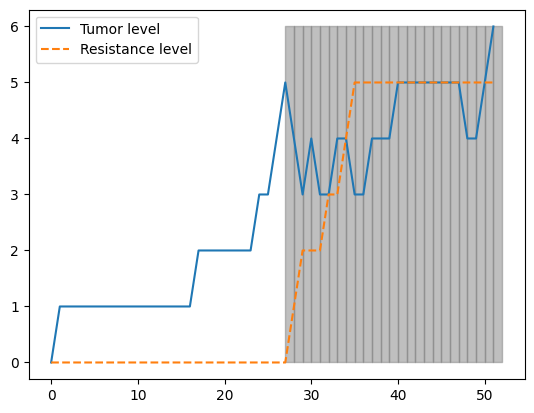

In [12]:
#reset .env
env.reset()

#make and empty list of dictionaries to store the states
dicts = []

#initialize the adaptive strategy
adaptive_strategy = "Dont treat"

## Simulation Loop 
for i in range(100):

    tumor_state, resistance_state, treatment_state = env.step(adaptive_strategy)
    
    #when tumor level hits 4, begin treatment
    if tumor_state > 4:
        adaptive_strategy = treatment_action_names[1]

    #when it comes below 1, stop treatment
    if tumor_state < 2:
        adaptive_strategy = treatment_action_names[0]
  
    #store states in a dictionary
    state_dict = {'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': adaptive_strategy}

    #append the dictionary to the list of dictionaries
    dicts.append(state_dict)
    if tumor_state == 6:
        break

#convert the list of dictionaries to a pandas dataframe
df = pd.DataFrame(dicts)


#plot the tumor state and resistance state
plt.plot(df['tumor_state'], label = 'Tumor level')
plt.plot(df['resistance_state'], label = 'Resistance level', linestyle = '--')

#shade in when treatment is on
for i in range(len(df)):
    if df['treatment_state'][i] == 'treat':
        plt.fill_between(x = [i, i+1], y1 = 0, y2 = 6, color = 'gray', alpha = 0.5)

#show the labels
plt.legend()

## setup agent


In [13]:

policy_len = 10

policies = pymdp.control.construct_policies(num_states= [6], num_controls = [2], policy_len=policy_len, control_fac_idx= [0])

for i, pol_i in enumerate(policies):
    policies[i] = (np.hstack((pol_i, pol_i, pol_i)))

agent = pymdp.agent.Agent(A = A, B = B, C = C, D = D, num_controls =[2,2,2], policies=policies, inference_horizon=10)

agent_dicts = []

#setup enviroment
o = env.reset()

action_idx = 0

agent.reset()

## Simulation Loop 
for i in range(100):

    #set the action from last round
    action = treatment_action_names[action_idx]

    #read values from env
    tumor_state, resistance_state, treatment_state = env.step(action)

    #set observation to tumor state, and current treatment
    o = (tumor_state, treatment_state)

    agent.infer_states(o)
    #do whatever infer_policies does
    q_pi, EFE = agent.infer_policies()

    agent.get_future_qs()

    #sample and action
    sampled_action  = agent.sample_action()

    agent.step_time()

    #comvert to index to use in setting action of next round
    action_idx = int(sampled_action[2])
  
    #store states in a dictionary
    state_dict = {'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': action}

    #append the dictionary to the list of dictionaries
    agent_dicts.append(state_dict)
    if tumor_state == 6:
        break

    print(action)

#convert the list of dictionaries to a pandas dataframe
df = pd.DataFrame(agent_dicts)


#plot the tumor state and resistance state
plt.plot(df['tumor_state'], label = 'Tumor level')
plt.plot(df['resistance_state'], label = 'Resistance level', linestyle = '--')

#shade in when treatment is on
for i in range(len(df)):
    if df['treatment_state'][i] == 'treat':
        plt.fill_between(x = [i, i+1], y1 = 0, y2 = 6, color = 'gray', alpha = 0.5)

#show the labels
plt.legend()





dont treat
dont treat
dont treat
dont treat
dont treat
treat
treat
dont treat
treat
treat
dont treat
dont treat
dont treat
dont treat
treat
dont treat
dont treat
dont treat
dont treat
dont treat
dont treat
dont treat
treat
dont treat
dont treat
dont treat
dont treat
dont treat
dont treat
dont treat
dont treat
treat
treat
dont treat
treat
treat
dont treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
dont treat
dont treat
dont treat
dont treat
dont treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
treat
